# Transfer Learning with Pre-trained Models [3 points]
Use in-build models with pre-trained weights and apply them to the Food-11 dataset.

## Step 1: Select at least THREE different pre-trained models
Selected at least THREE different pre-trained models, e.g. ShuffleNet, Inception V3, and MobileNet V3. Check PyTorch documentation for more details. Justify your choice of models, considering their architectural strengths and suitability for the task.

In [ ]:
import os
import zipfile
import random
import time
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR


In [ ]:
zip_path = "archive.zip"
extract_path = "food_dataset"

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")

Extracting dataset...
Extraction complete!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


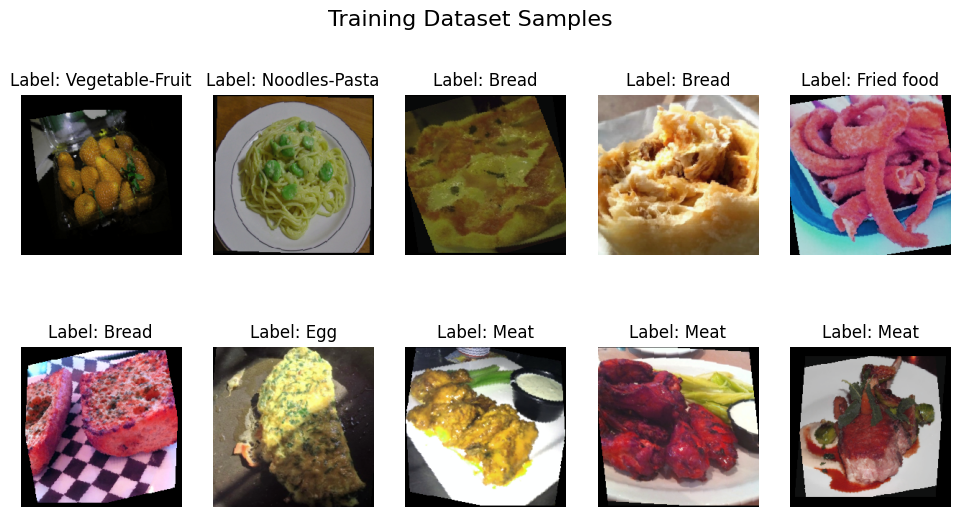

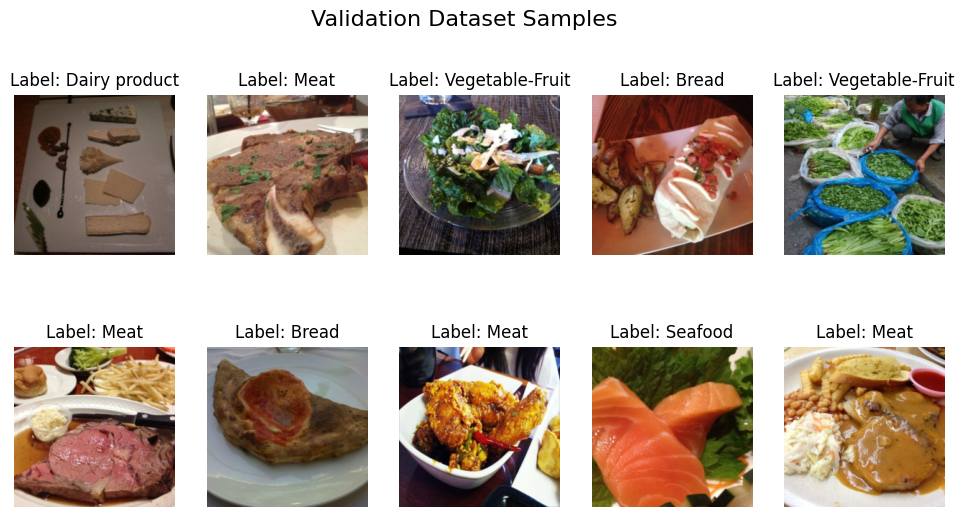

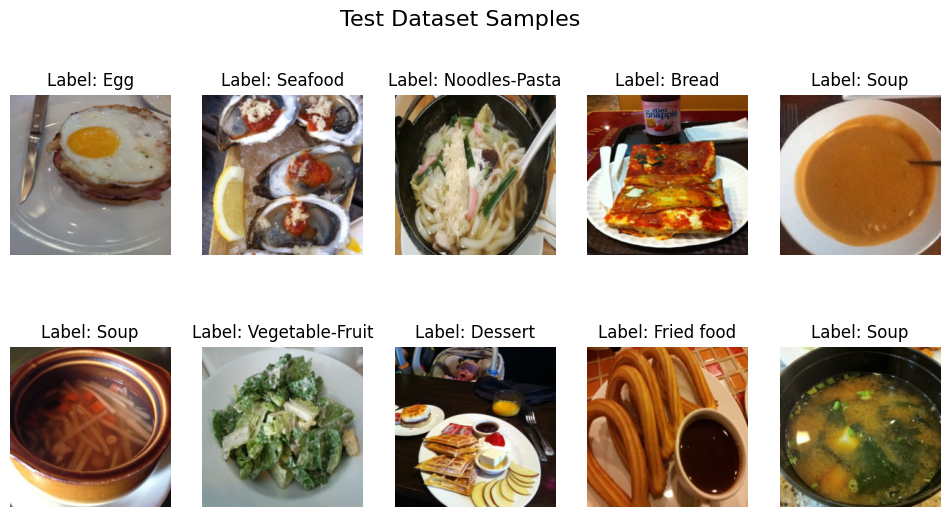

Training Dataset Size: 9866 images
Validation Dataset Size: 3430 images
Test Dataset Size: 3347 images


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = "food_dataset"
train_dataset = ImageFolder(root=f"{dataset_path}/training", transform=transform_train)
val_dataset = ImageFolder(root=f"{dataset_path}/validation", transform=transform)
test_dataset = ImageFolder(root=f"{dataset_path}/evaluation", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def show_samples(dataset, title, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for ax, idx in zip(axes.flatten(), indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        ax.imshow(image)
        ax.set_title(f"Label: {dataset.classes[label]}")
        ax.axis("off")

    plt.show()

show_samples(train_dataset, "Training Dataset Samples")
show_samples(val_dataset, "Validation Dataset Samples")
show_samples(test_dataset, "Test Dataset Samples")

print(f"Training Dataset Size: {len(train_dataset)} images")
print(f"Validation Dataset Size: {len(val_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")


In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluates the model on a given dataset (Validation or Test)

    Args:
        model: The trained model.
        data_loader: DataLoader for validation or test dataset.
        criterion: Loss function.
        device: 'cuda' or 'cpu'.

    Returns:
        avg_loss: Average loss across all batches.
        accuracy: Accuracy percentage.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001,
                batch_size=32, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau"):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()


    if optimizer_type.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError("Invalid optimizer choice. Use 'adam' or 'sgd'.")


    if scheduler_type.lower() == "plateau":
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
    elif scheduler_type.lower() == "step":
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        scheduler = None


    history = {}

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)

        avg_val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        if scheduler:
            if scheduler_type.lower() == "plateau":
                scheduler.step(avg_val_loss)  # Reduce LR when loss plateaus
            else:
                scheduler.step()

        epoch_time = time.time() - start_time

        history[epoch] = {
            "train_loss": avg_train_loss,
            "train_acc": train_acc,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "time": epoch_time
        }

        print(f"Epoch [{epoch}/{num_epochs}] - Time: {epoch_time:.2f}s")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

    return model, history

def test_model(model, test_loader):
    """
    Tests the trained model on the test dataset.

    Args:
        model: Trained model.
        test_loader: DataLoader for test dataset.

    Returns:
        Prints the test accuracy.
    """
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%\n")


<span style='color:green'>### YOUR ANSWER ###</span>


The 3 models are ShuffleNet V2, Squeeze Net and MobileNetV3.The reasons for choosing these models are given Below



1.   Shufflenet V2

  ShuffleNet V2 is  balances accuracy and computational cost, making it suitable for deployment in  environments that are having resource crunch

   *   It reduces memory usage by using equal number of output channels in each branch to simplify implementation.It implements splitting features and mixing them via channel shuffle to allow cross-group information exchange without excessive overhead  

   *  Avoiding extra memory reads and writes  increases the running speed
   *  It is is still scalable to different complexity levels

2.   Squeezenet

    SqueezeNet aims to reduce the model size while maintaining high accuracy for image classification tasks. It accomplishes this by employing a novel architectural design that aggressively reduces the number of parameters without significantly compromising performance.



  * By squeezing the input channels with 1×1 convolutions, the
      subsequent 3×3 convolutions operate on fewer input channels, thus greatly reducing overall parameters.

  *  With  data augmentation, regularization, and hyperparameter tuning ,
     SqueezeNet can get accuracy similar to much larger architectures in many tasks.

  * SqueezeNet’s small size also speeds up training




3.   Mobilenet V3

     MobileNetV3, a cutting-edge architecture for efficient deep learning models designed for mobile devices. It is the third generation of the MobileNet family. MobileNets are **lightweight convolutional neural networks** optimized for speed and accuracy. MobileNetV3 introduces new architecture improvements, such as platform-aware neural architecture search (NAS) and NetAdapt, to further enhance performance.



*   **channel attention** is implemented using Squeeze-and-Excitation (SE) blocks, which learn to selectively emphasize or suppress channels based on global context. Each block begins by performing global average pooling on the feature maps to capture the overall channel-wise statistics, then passes these pooled values through a small pair of fully connected layers.This helps the network focus on the most informative features while ignoring irrelevant channels, leading to improved representational power with a minimal increase in computational cost.
*   Designed for higher accuracy, uses slightly more computational resources.












## Step 2: For each chosen model

### a. Load the pre-trained model and modify the classification head
Load the pre-trained model and modify the classification head (the final fully connected layer) to match the number of classes in the Food-11 dataset.

In [ ]:
### ADD YOUR CODE HERE ###
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
shufflenet.fc = nn.Linear(shufflenet.fc.in_features, 11)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
squeezenet = models.squeezenet1_0(pretrained=True)
squeezenet.classifier[1] = nn.Conv2d(512, 11 , kernel_size=1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet.classifier[3] = nn.Linear(mobilenet.classifier[3].in_features,11)


### b. Fine-tune the model
Fine-tune the model. Experiment with different hyperparameter settings (learning rate, batch size, etc.) to optimize performance. Explain your tuning strategy.

Shuffle net batch 32 and learning rate 0.001

In [ ]:
### ADD YOUR CODE HERE ###
trained_shufflenet, history_shufflenet = train_model(shufflenet, train_loader, val_loader, num_epochs=5, learning_rate=0.001, batch_size=32, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau")


Epoch [1/5] - Time: 146.70s
Train Loss: 1.2161 | Train Acc: 61.35% | Val Loss: 0.6860 | Val Acc: 77.76%

Epoch [2/5] - Time: 146.25s
Train Loss: 0.7371 | Train Acc: 75.72% | Val Loss: 0.6800 | Val Acc: 77.78%

Epoch [3/5] - Time: 145.53s
Train Loss: 0.6235 | Train Acc: 79.14% | Val Loss: 0.6042 | Val Acc: 80.17%

Epoch [4/5] - Time: 146.41s
Train Loss: 0.5838 | Train Acc: 80.37% | Val Loss: 0.5304 | Val Acc: 83.03%

Epoch [5/5] - Time: 146.63s
Train Loss: 0.5142 | Train Acc: 82.93% | Val Loss: 0.5488 | Val Acc: 82.45%



shufflenet batch 64 and learning rate 0.001

In [ ]:
shufflenet2 = models.shufflenet_v2_x1_0(pretrained=True)
shufflenet2.fc = nn.Linear(shufflenet2.fc.in_features, 11)
trained_shufflenet2, history_shufflenet2 = train_model(shufflenet2, train_loader, val_loader, num_epochs=5, learning_rate=0.0001, batch_size=64, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau")


Epoch [1/5] - Time: 147.07s
Train Loss: 2.0313 | Train Acc: 38.98% | Val Loss: 1.5953 | Val Acc: 57.70%

Epoch [2/5] - Time: 146.63s
Train Loss: 1.3213 | Train Acc: 61.97% | Val Loss: 0.9444 | Val Acc: 73.64%

Epoch [3/5] - Time: 145.93s
Train Loss: 0.9426 | Train Acc: 71.25% | Val Loss: 0.7089 | Val Acc: 76.73%

Epoch [4/5] - Time: 145.95s
Train Loss: 0.7464 | Train Acc: 76.91% | Val Loss: 0.5654 | Val Acc: 82.92%

Epoch [5/5] - Time: 144.83s
Train Loss: 0.6123 | Train Acc: 81.63% | Val Loss: 0.5088 | Val Acc: 84.20%



Squeezenet batch 32 and learning rate 0.001

In [ ]:
trained_squeezenet, history_squeezenet = train_model(squeezenet, train_loader, val_loader, num_epochs=5, learning_rate=0.001, batch_size=32, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5] - Time: 161.12s
Train Loss: 2.3040 | Train Acc: 16.89% | Val Loss: 2.2386 | Val Acc: 21.72%

Epoch [2/5] - Time: 156.78s
Train Loss: 2.2122 | Train Acc: 21.40% | Val Loss: 2.2347 | Val Acc: 22.48%

Epoch [3/5] - Time: 156.84s
Train Loss: 2.1714 | Train Acc: 22.53% | Val Loss: 2.1276 | Val Acc: 24.84%

Epoch [4/5] - Time: 157.06s
Train Loss: 2.1230 | Train Acc: 24.68% | Val Loss: 2.0984 | Val Acc: 24.34%

Epoch [5/5] - Time: 157.12s
Train Loss: 2.0811 | Train Acc: 25.87% | Val Loss: 2.1294 | Val Acc: 25.22%



Squeezenet batch 64 and learning rate 0.0001

In [ ]:
squeezenet2 = models.squeezenet1_0(pretrained=True)
squeezenet2.classifier[1] = nn.Conv2d(512, 11 , kernel_size=1)
trained_squeezenet2, history_squeezenet2 = train_model(squeezenet2, train_loader, val_loader, num_epochs=5, learning_rate=0.0001, batch_size=64, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5] - Time: 157.59s
Train Loss: 1.4145 | Train Acc: 52.83% | Val Loss: 1.0178 | Val Acc: 67.52%

Epoch [2/5] - Time: 157.15s
Train Loss: 1.0000 | Train Acc: 66.42% | Val Loss: 0.8709 | Val Acc: 70.64%

Epoch [3/5] - Time: 157.58s
Train Loss: 0.8564 | Train Acc: 71.58% | Val Loss: 0.8059 | Val Acc: 74.26%

Epoch [4/5] - Time: 156.62s
Train Loss: 0.7891 | Train Acc: 73.77% | Val Loss: 0.7942 | Val Acc: 73.15%

Epoch [5/5] - Time: 157.02s
Train Loss: 0.7338 | Train Acc: 76.13% | Val Loss: 0.6731 | Val Acc: 78.13%



In [ ]:
trained_mobilenet, history_mobilenet = train_model(mobilenet, train_loader, val_loader, num_epochs=5, learning_rate=0.001, batch_size=32, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5] - Time: 158.70s
Train Loss: 0.9030 | Train Acc: 70.56% | Val Loss: 0.9852 | Val Acc: 73.53%

Epoch [2/5] - Time: 156.56s
Train Loss: 0.6098 | Train Acc: 79.79% | Val Loss: 0.7992 | Val Acc: 74.78%

Epoch [3/5] - Time: 161.66s
Train Loss: 0.5262 | Train Acc: 82.83% | Val Loss: 0.8492 | Val Acc: 75.71%

Epoch [4/5] - Time: 156.14s
Train Loss: 0.4696 | Train Acc: 83.92% | Val Loss: 0.5307 | Val Acc: 84.37%

Epoch [5/5] - Time: 155.98s
Train Loss: 0.4320 | Train Acc: 85.47% | Val Loss: 0.6601 | Val Acc: 79.62%



In [ ]:
mobilenet2 = models.mobilenet_v3_large(pretrained=True)
mobilenet2.classifier[3] = nn.Linear(mobilenet2.classifier[3].in_features,11)
trained_mobilenet2, history_mobilenet2 = train_model(mobilenet2, train_loader, val_loader, num_epochs=5, learning_rate=0.0001, batch_size=64, optimizer_type="adam", weight_decay=1e-4, scheduler_type="plateau")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5] - Time: 174.32s
Train Loss: 1.0275 | Train Acc: 66.52% | Val Loss: 0.4821 | Val Acc: 84.46%

Epoch [2/5] - Time: 173.66s
Train Loss: 0.4815 | Train Acc: 84.14% | Val Loss: 0.3892 | Val Acc: 87.49%

Epoch [3/5] - Time: 173.27s
Train Loss: 0.3692 | Train Acc: 87.83% | Val Loss: 0.3494 | Val Acc: 88.48%

Epoch [4/5] - Time: 171.40s
Train Loss: 0.2869 | Train Acc: 90.48% | Val Loss: 0.3346 | Val Acc: 89.18%

Epoch [5/5] - Time: 172.77s
Train Loss: 0.2265 | Train Acc: 92.58% | Val Loss: 0.3430 | Val Acc: 88.83%



<span style='color:green'>### YOUR ANSWER ###</span>

### c. Evaluate the performance of each fine-tuned model
Evaluate the performance of each fine-tuned model on the Food-11 dataset.

In [ ]:
### ADD YOUR CODE HERE ###
test_model(trained_shufflenet, test_loader)


Test Loss: 0.4638 | Test Accuracy: 84.08%



In [ ]:
test_model(trained_shufflenet2, test_loader)

Test Loss: 0.4360 | Test Accuracy: 86.11%



In [ ]:
test_model(trained_squeezenet, test_loader)

Test Loss: 2.1168 | Test Accuracy: 26.47%



In [ ]:
test_model(trained_squeezenet2, test_loader)

Test Loss: 0.5929 | Test Accuracy: 79.92%



In [ ]:
test_model(trained_mobilenet, test_loader)

Test Loss: 0.5997 | Test Accuracy: 82.19%



In [ ]:
test_model(trained_mobilenet2, test_loader)

Test Loss: 0.3044 | Test Accuracy: 90.29%



In [ ]:
model_save_path = "best.pt"

# Save the model's state_dict (weights & biases)
torch.save(trained_mobilenet2.state_dict(), model_save_path)

### d. Compare the results obtained with the different pre-trained models
Discuss which model performed best and analyze the reasons for the observed differences in performance.

<span style='color:green'>### YOUR ANSWER ###</span>

For all 3 models we took 2 sets of paramters (batch size -32 and lr - 0.001 ) and (batch-size-64 and lr-0.0001)



1.   ShuffleNet

      Accuracy increases from 84.08% to 86.11% because lower learning rate prevents overshooting gradient updates which helps in better convergence and a larger batch size smoothens gradient estimates

2.   Squeezenet

     Accuracy increases from 26.47% to 79.92% because squeezenet if very sensitive to learning rate , the reduction of learning rate from 0.001 to 0.001 caused the massive jump in accuracy . this along with increasing batch size stabilized training and improved convergence


3.   MobilenetV3

      Accuracy increases from 82.19% to 90.29%.Change in parameters helped model to more smoothly , avoiding large, destabilizing weight changes


## Step 3: References
Include details on all the resources used to complete this part.

<span style='color:green'>### YOUR ANSWER ###</span>


[Shuffle net Paper](https://arxiv.org/abs/1807.11164v1)

[Pytorch Shufflenet](https://pytorch.org/hub/pytorch_vision_shufflenet_v2/)

[Medium.com Shufflenet](https://medium.com/thedeephub/shufflenet-v2-overview-56c965dd7cef)

[Medium Squeezenet](https://medium.com/@zakhtar2020/squeezenet-overview-fc3cf0511535)

[Pytorch squeezenet](https://pytorch.org/hub/pytorch_vision_squeezenet/)

[Medium Mobilenet](https://medium.com/@RobuRishabh/understanding-and-implementing-mobilenetv3-422bd0bdfb5a)

[Pytorch Mobilenet](https://pytorch.org/vision/main/models/mobilenetv3.html)